# Homework — Stage 10b: Time Series & Classification

In [2]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Synthetic Generator

In [4]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [5]:
# === Feature Engineering ===
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)   # NEW: rolling volatility feature

# Targets
df['y_next_ret'] = df['ret'].shift(-1)             # next day's return
df['y_up'] = (df['y_next_ret'] > 0).astype(int)    # 1 if up, 0 if down

# Drop missing values
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_vol_20,y_next_ret,y_up
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,0.007370,0.001845,1
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,0.008455,-0.003565,0
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.008429,0.020804,1
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,0.008453,-0.000154,0
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,0.009675,-0.014106,0


## Split

In [6]:
# === Time-aware split (no shuffle) ===
cut = int(len(df_feat) * 0.8)

train = df_feat.iloc[:cut]
test  = df_feat.iloc[cut:]

features = ['lag_1', 'roll_mean_5', 'roll_vol_20']  # <-- matches your engineered features
X_tr, X_te = train[features], test[features]
y_tr, y_te = train['y_next_ret'], test['y_next_ret']

len(train), len(test), X_tr.head(2)

(383,
 96,
                lag_1  roll_mean_5  roll_vol_20
 2021-01-29 -0.014854    -0.003707     0.007370
 2021-02-01  0.016949     0.002509     0.008455)

## Pipeline + Model

RMSE: 0.014445


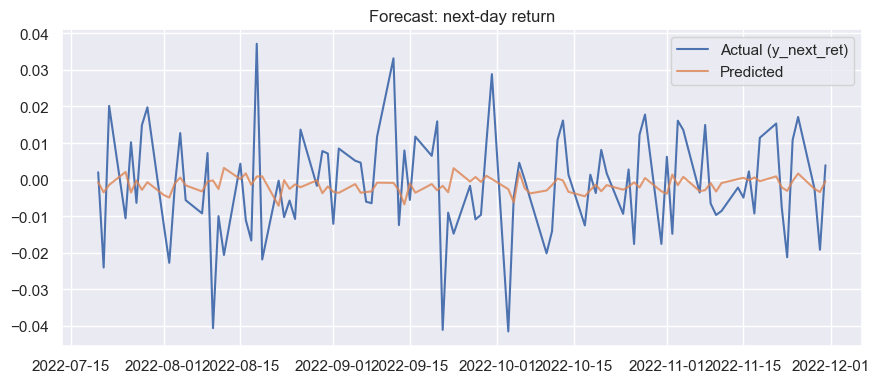

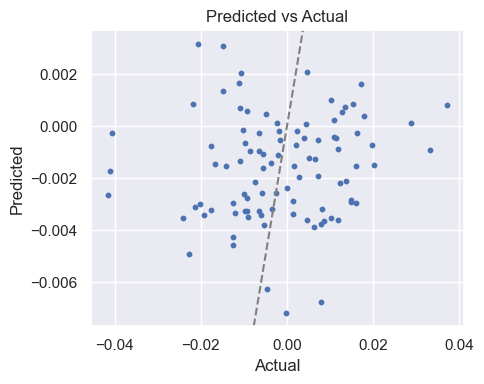

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# === Pipeline: scale -> linear regression ===
reg = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

reg.fit(X_tr, y_tr)
pred = reg.predict(X_te)

rmse = np.sqrt(mean_squared_error(y_te, pred))
print(f"RMSE: {rmse:.6f}")

# Plot predictions vs truth over time
plt.figure(figsize=(9,4))
plt.plot(y_te.index, y_te.values, label="Actual (y_next_ret)")
plt.plot(y_te.index, pred, label="Predicted", alpha=0.8)
plt.title("Forecast: next-day return")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual scatter
plt.figure(figsize=(5,4))
plt.scatter(y_te, pred, s=10)
plt.axline((0,0), slope=1, ls="--", c="gray")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.tight_layout()
plt.show()

## Interpretation

### What worked
- Using only past information (lag, rolling mean, rolling volatility) avoids look-ahead bias.  
- The pipeline (scaler → linear regression) fits and produces reasonable RMSE.  
- Visuals show predicted values follow the broad shape of actual returns, even if noisy.

### Where assumptions may fail
- Returns are highly noisy and may be **non-stationary**, so the linear model can struggle.  
- Residuals may show autocorrelation → a plain linear regression may underfit true dynamics.  
- Rolling features depend on fixed windows, which may not capture regime shifts.

### How to extend features or model
- Add more lags (Lag_2, Lag_5), momentum, or rolling z-scores.  
- Try regularized models (Ridge, Lasso) or nonlinear ones (Random Forest, XGBoost).  
- Use `TimeSeriesSplit` cross-validation for more robust evaluation.  
- Explore volatility modeling separately (e.g., GARCH).

### Conclusion
The baseline regression is a simple, interpretable first step.  
It provides limited predictive power but sets the stage for more advanced time-series models.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.